<a href="https://colab.research.google.com/github/JanaAliCS/machine_leanring/blob/main/session%202/session2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Scoring Dataset – First Look
In this session, you will:
- Explore a raw dataset for credit scoring.
- Identify and fix common data quality issues.
- Engineer new features useful for predicting credit risk.

The dataset mimics real-world bank data, with deliberate issues (missing values, outliers, duplicates).

> **Note for Students**  
> This dataset is **synthetic** and created for **academic purposes only**.  
> It is not real customer data, but it mimics some of the real issues (like missing values, inconsistent categories, and outliers) that we often face in actual credit scoring use cases.


In [47]:
import pandas as pd
import plotly.express as px
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Section 1: Quick EDA (Exploratory Data Analysis)
Before cleaning and feature engineering, let's understand the dataset.

Goals:
- Check dataset shape and column types
- Inspect distributions of numeric variables
- Explore categorical variables
- Identify issues: missing values, outliers, inconsistencies

### Step 1.1 – Dataset Overview
- Check shape and column types
- Preview first rows

In [48]:
# TODO: Read the CSV file into a DataFrame
df = pd.read_csv('https://raw.githubusercontent.com/kelkess43/AUC-Material/refs/heads/main/session%202/credit_scoring.csv')

In [49]:
# TODO: Preview the first 10 rows of the dataset
df.head(10)

,customer_id,age,gender,income,employment_type,education,total_debt,balance,credit_limit,late_payments,monthly_balance,default
0,1,38.0,Male,30250.0,Salaried,PhD,25531,8894,10217,2,2541,0
1,2,18.0,Female,18709.0,Salaried,Bachelor,14517,10346,15245,3,2692,1
2,3,34.0,Male,4563.0,Salaried,Master,39234,10962,17609,2,2957,0
3,4,56.0,Female,48782.0,Salaried,Bachelor,12253,21960,12636,3,2398,0
4,5,38.0,Male,47630.0,Self employed,Master,3108,-496,18226,0,4165,0
5,6,24.0,Male,32569.0,Unemployed,High School,15287,13416,16838,1,1395,0
6,7,24.0,Male,16524.0,Self employed,Master,245,9425,9010,1,1827,0
7,8,28.0,Male,14239.0,Salaried,High School,27510,12833,18112,5,3181,1
8,9,31.0,Female,18144.0,Salaried,Master,-650,6713,20181,5,2448,0
9,10,19.0,Male,6008.0,Unemployed,PhD,20284,9755,16028,3,1336,1


### Step 1.2 – Summary Statistics
- Describe numeric variables
- Count categorical values

In [50]:
# TODO: check data types and non-null counts
df.info()
# or we can use df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customer_id      1010 non-null   int64  
 1   age              960 non-null    float64
 2   gender           1010 non-null   object 
 3   income           990 non-null    float64
 4   employment_type  960 non-null    object 
 5   education        1010 non-null   object 
 6   total_debt       1010 non-null   int64  
 7   balance          1010 non-null   int64  
 8   credit_limit     1010 non-null   int64  
 9   late_payments    1010 non-null   int64  
 10  monthly_balance  1010 non-null   int64  
 11  default          1010 non-null   int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 94.8+ KB


In [51]:
# TODO: Check value counts for 'employment_type'
df['employment_type'].value_counts()
# (dropna) by default is true otherwise say (dropna=false) this shows a new row for NaN


,count
employment_type,
Salaried,578
Self-Employed,156
Self employed,143
Unemployed,83


### Step 1.3 – Missing Values
- Identify columns with NaN
- Check proportions of missing


*Explanation*: Missing values can bias results. Small amounts may be dropped, but important fields are often imputed with logical strategies.

In [52]:
# TODO: Find missing values in each column
df.isnull().sum()
#or df.isna().sum()
#there could be a relation between two variables if they have the same number of nulls (ex from below: employment and gender)

,0
customer_id,0
age,50
gender,0
income,20
employment_type,50
education,0
total_debt,0
balance,0
credit_limit,0
late_payments,0


### Step 1.4 – Distributions & Outliers
- Plot histograms for numeric columns
- Use boxplots to detect outliers


*Explanation*: Visualizing distributions helps detect skewness, outliers, or unrealistic values (e.g., negative income).

In [53]:
fig = px.histogram(df, x="age", nbins=30, title="Age Distribution")
fig.show()
#using here plotply (interactive)
#there are ages in negative (need to be handled -> assume or see if there is a glitch)

In [54]:
# TODO: Create a histogram to visualize income distribution
fig = px.histogram(df, x="income", nbins=30, title="Income Distribution")
fig.show()
#income is righlty skewed (need to be handles later on)

In [55]:

fig = px.histogram(df, x="monthly_balance", nbins=30, title="Monthly Balance Distribution")
fig.show()


In [56]:
# TODO: Create a boxplot to check for outliers in monthly_balance
px.box(df, x="monthly_balance", title="Monthly Balance Box Plot")
#it uses the median for average

**Interpretation:**

- Income shows wide variation, with some higher earners but many around lower ranges.
- Monthly balance has outliers — some customers go very negative or very high.

### Step 1.5 – Target Variable
- Check distribution of the target
- See if classes are balanced (default vs non-default)

*Explanation*: Checking class balance is critical. If imbalanced, advanced techniques like resampling or weighted models may be needed.

In [57]:

# TODO: Print raw counts of default vs non-default instead of percentages
df['default'].value_counts(normalize=True)
#normalize makes it a percentage (can remove it)


,proportion
default,
0,0.781188
1,0.218812


In [58]:

# Distribution of default vs non-default
default_dist = df['default'].value_counts(normalize=True).reset_index()
default_dist.columns = ['default', 'proportion']

fig = px.bar(
    default_dist,
    x='default',
    y='proportion',
    text='proportion',
    title="Default vs Non-default Distribution",
    labels={'default': 'Class', 'proportion': 'Proportion'}
)
#the text, title, lables 7agat bt5ly el graph readable w no need to memorize
fig.update_traces(texttemplate='%{text:.2%}', textposition='outside')
fig.update_yaxes(tickformat=".0%")
fig.show()



### Class Imbalance Note

In this dataset, about 20% of customers are **defaults** while 80% are **non-defaults**. This reflects a realistic imbalance: most customers repay their loans. However, this imbalance means accuracy alone is misleading — we need to also look at precision, recall, and F1.

# Section 2: Data Cleaning
Now we fix issues found in EDA.

Goals:
- Handle missing values, duplicates, and outliers.
- Standardize categories and check data consistency.

### Step 2.1 – Handle Missing Values
Choose a strategy:
- Drop rows
- Fill with mean/median/mode
- Use domain knowledge (e.g., employment type → "Unknown")


*Explanation*: Imputation choice depends on distribution. Median is safer with skewed data (like income), while mean works for normally distributed data.

In [59]:
# TODO: Fill missing values for 'age' and 'employment_type'
df['age'] = df['age'].fillna(df['age'].median())
df['employment_type'] = df['employment_type'].fillna("Unknown")
#mode can be used in categorical data-> here cannot be used bec this column is critical in terms of the overall model (value maserya)

In [60]:
df['employment_type'].isna().sum()

np.int64(0)

In [61]:
df['income'] = df['income'].fillna(df['income'].median())

### Step 2.2 – Remove Duplicates
- Check duplicate rows
- Drop if necessary

*Explanation*: Duplicates usually arise from repeated entries. Always confirm before dropping, since some repeats may be legitimate.

In [62]:

# TODO: Remove duplicate rows from the dataset
df = df.drop_duplicates()

In [34]:
df.drop_duplicates(inplace=True)
#same as the line above it bas inplace takes up more space so not preferrable

### Step 2.3 – Standardize Categories
- Fix inconsistent labels
- Ensure uniform formatting (e.g., lowercase)


*Explanation*: Standardizing categories avoids treating 'Self employed' and 'self-employed' as separate groups.

In [63]:
# TODO: Standardize categories in 'employment_type'
# Hint: lowercase and strip spaces
df['employment_type'].str.lower().str.strip().str.replace('-', ' ').value_counts()
#preferably do not use df[] = sth because this overwrites the original column immediately (otherwise reread the csv file)

,count
employment_type,
salaried,578
self employed,299
unemployed,83
unknown,50


### Step 2.4 – Treat Outliers
- Cap extreme values
- Or replace with thresholds

*Explanation*: Outliers can heavily influence models. Options include capping, transformation (log), or removal.

In [64]:
# Solved example: cap outliers at 99th percentile
cap = df['monthly_balance'].quantile(0.99)
df['monthly_balance'] = np.where(df['monthly_balance'] > cap, cap, df['monthly_balance'])
#ways of handling outliers: 1.remove 2.make another distribution for them 3.capping-> badehom a max/min so i can keep them


### Step 2.5 – Validate Logic
- Check impossible values (e.g., negative age)


In [82]:
df['age'] = np.where(df['age'] < 0, abs(df['age']), df['age'])
#if less than 0 then use absolute otherwise use the age

# Section 3: Feature Engineering
We create new features that add business insight.

Goals:
- Encode categorical variables.
- Build useful ratios (e.g., debt-to-income, credit utilization).
- Group variables (e.g., age buckets).

### Step 3.1 – Encode Categorical Variables
- Convert categories into numeric form (e.g., one-hot encoding)
- Avoid implying order in non-ordinal categories

*Explanation*: Encoding turns categories into numeric form. One-hot encoding avoids implying order in non-ordinal categories.


In [71]:
# Solved example: encode 'education'
df = pd.get_dummies(df, columns=['education'], drop_first=True)
#drop first drops a column


In [75]:

# TODO: Encode other categorical variables like 'employment_type' and 'gender'
df = pd.get_dummies(df, columns=['employment_type', 'gender'], drop_first=True)


### Step 3.2 – Create Ratios
- Debt-to-Income Ratio
- Credit Utilization (%)

*Explanation*: Ratios like debt-to-income capture relative financial health better than raw numbers.


In [76]:
# Solved example: Debt-to-Income ratio
df['debt_to_income'] = df['total_debt'] / (df['income']+1)
#we add +1 3shan law fe 7ad 3ndo income 0 mt3mlsh moshkela


In [77]:
# TODO: Create credit utilization (balance / credit_limit)
df['credit_utilization'] = df['monthly_balance'] / (df['credit_limit']+1)

### Step 3.3 – Group Continuous Variables
- Age buckets
- Income ranges

*Explanation*: Bucketing continuous variables can reveal non-linear relationships (e.g., young borrowers may behave differently).  
It also makes it easier to compare customers across categories (e.g., low-income vs high-income).


In [96]:
df['age_group'] = pd.cut(df['age'], bins=[15,30,50,100], labels=['Young','Mid','Senior'], right=False)
#using right=false y3ny ht exclude the 100 mesh el 15 (at first it wrote 15 as Nan)
df['income_group'] = pd.cut(df['income'], bins=[df['income'].min(),
                                                df['income'].quantile(0.25),
                                                df['income'].quantile(0.5),
                                                df['income'].quantile(0.75),
                                                df['income'].max()],
                                                labels=['poor', 'middle', 'upper', 'rich'])

# TODO: Create alternative age groups with different splits

# TODO: Create income ranges

## 🔍 Feature Insights After Engineering

Now that we created **debt-to-income ratio, credit utilization, age groups, and income groups**, we can visualize how these engineered features relate to default risk.

The goal is to see whether these transformations reveal clearer patterns compared to the raw features.

In [97]:
# Solved example: Debt-to-Income vs Default
fig1 = px.box(
    df,
    x='default',
    y='debt_to_income',
    title='Debt-to-Income Ratio vs Default',
)
fig1.show()

# TODO: Plot Credit Utilization vs Default
# Hint: Use px.box with 'default' on x-axis and 'credit_utilization' on y-axis
fig2 = px.box(
    df,
    x='default',
    y='credit_utilization',
    title='Credit Utilization'
)
fig2.show()

# Solved example: Default rate by Income Group
income_group_default = df.groupby('income_group')['default'].mean().reset_index()
fig3 = px.bar(
    income_group_default,
    x='income_group',
    y='default',
    title='Default Rate by Income Group'
)
fig3.show()

# TODO: Plot Default rate by Age Group
# Hint: Group by 'age_group' and calculate mean default rate, then use px.bar
age_group_default = df.groupby('age_group')['default'].mean().reset_index()
fig4 = px.bar(
    age_group_default,
    x='age_group',
    y='default',
    title='Default Rate by Age Group'
)
fig4.show()

/tmp/ipython-input-1634001997.py:21: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



/tmp/ipython-input-1634001997.py:32: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [98]:
df

,customer_id,age,income,total_debt,balance,credit_limit,late_payments,monthly_balance,default,age_group,...,education_High School,education_Master,education_PhD,employment_type_Self employed,employment_type_Self-Employed,employment_type_Unemployed,employment_type_Unknown,gender_Male,debt_to_income,credit_utilization
0,1,38.0,30250.0,25531,8894,10217,2,2541.0,0,Mid,...,False,False,True,False,False,False,False,True,0.843972,0.248679
1,2,18.0,18709.0,14517,10346,15245,3,2692.0,1,Young,...,False,False,False,False,False,False,False,False,0.775895,0.176571
2,3,34.0,4563.0,39234,10962,17609,2,2957.0,0,Mid,...,False,True,False,False,False,False,False,True,8.596407,0.167916
3,4,56.0,48782.0,12253,21960,12636,3,2398.0,0,Senior,...,False,False,False,False,False,False,False,False,0.251174,0.189760
4,5,38.0,47630.0,3108,-496,18226,0,4165.0,0,Mid,...,False,True,False,True,False,False,False,True,0.065252,0.228507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,899,30.0,27797.0,26324,2606,16081,2,4302.0,0,Mid,...,False,True,False,False,False,False,False,True,0.946975,0.267504
1006,773,42.0,5568.0,13345,7406,27385,2,3833.0,0,Mid,...,False,False,False,False,True,False,False,False,2.396301,0.139962
1007,755,31.0,20364.0,25188,11691,4736,5,2131.0,1,Mid,...,False,True,False,False,False,False,False,False,1.236828,0.449863
1008,311,25.0,3811.0,9449,10397,9425,1,1329.0,0,Young,...,True,False,False,False,True,False,False,True,2.478751,0.140993


**Interpretation:**

- Customers with high **debt-to-income ratios** are clearly riskier.
- **Credit utilization** close to 1.0 (maxing out their credit limit) signals much higher default probability.

**Interpretation:**

- Lower income groups show a much higher proportion of defaults.

**Observations:**
- Customers with **higher debt-to-income ratios** are more likely to default.
- **Credit utilization above 0.8** signals higher default risk.
- Lower income groups have visibly higher default rates.

## Section 4: Simple Modelling

Now that the dataset is cleaned and features engineered, we can try a simple model.
- Split data into train/test sets
- Fit a Logistic Regression model
- Evaluate using accuracy, precision, recall, and F1-score

⚠️ Note: The goal is not to achieve the best model here, but to connect the data preparation steps with prediction.

Accuracy: 0.8151815181518152
              precision    recall  f1-score   support

           0       0.81      1.00      0.90       246
           1       1.00      0.02      0.03        57

    accuracy                           0.82       303
   macro avg       0.91      0.51      0.47       303
weighted avg       0.85      0.82      0.74       303



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



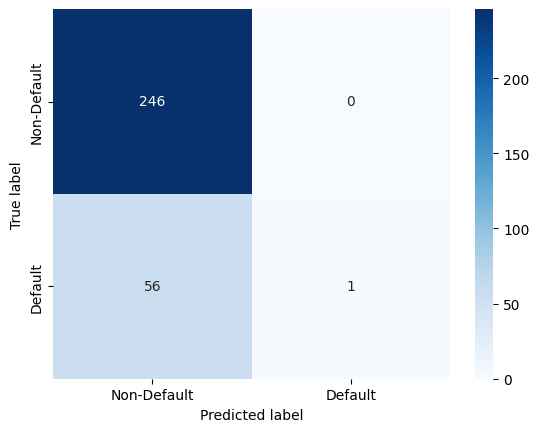

In [99]:

# Define target and features
y = df['default']
X = df.drop(columns=['default','customer_id'])

# One-hot encode categorical variables if any remain
X = pd.get_dummies(X, drop_first=True)

# Split into train and test (should be done first 3shan we dont do sth to test so it wont be misleading afterwards)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Logistic Regression
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Default','Default'], yticklabels=['Non-Default','Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()